# Load packages 

In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter
from functools import reduce

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


# Set up

In [2]:
##Write some informations on your assay that we will use later to have titles and save files + load files
name = "No azole DMS validations"
time = 24 #Needs to be a number, don't add the H after, ex : 24, 32, 36, 48, 72
date = "2023-10-04"
antifungal = "None"

OD_file = antifungal.lower() + "_dms_validations_cb_4_10_2023.xlsx"

select_coef_file = "select_coef_validations_mutants_2023_2023-10-04.xlsx"

#importation of excel plan of the concentrations and the strains in your plate (and the wells)
plan = antifungal.lower() + "_plan_validations_2023-10-04.xlsx"  ##change the name of the file

concentrations = pd.read_excel(plan, sheet_name='Sheet1', header=0, index_col=0) #sheet 1 = concentrations plan
strains = pd.read_excel(plan, sheet_name='Sheet2', header=0, index_col=0) #sheet 2 = strains plan
well = pd.read_excel(plan, sheet_name='Sheet3', header=0, index_col=0) #sheet 3 = well names plan
antifungals = pd.read_excel(plan, sheet_name='Sheet4', header=0, index_col=0) #sheet 4= antifungals plan
categories = pd.read_excel(plan, sheet_name='Sheet5', header=0, index_col=0) #sheet 5= categories

# Dataframe import 

In [3]:
#importation of excel output from the TECAN 
source_df = pd.read_excel(OD_file, header=0, index_col=0)
source_df.head()

,0s,900s,1800s,2700s,3599s,4499s,5399s,6299s,7199s,8099s,...,79195s,80095s,80995s,81895s,82795s,83695s,84595s,85495s,86395s,87294s
A1,0.13462,0.13003,0.13205,0.13316,0.13344,0.13546,0.13608,0.13796,0.14000,0.14156,...,1.0577,1.0574,1.0579,1.0594,1.0595,1.0609,1.0615,1.0633,1.0609,1.0605
A2,0.13483,0.13013,0.12938,0.13043,0.13100,0.13295,0.13388,0.13312,0.13545,0.13549,...,1.2427,1.2416,1.2399,1.2372,1.2333,1.2292,1.2267,1.2232,1.2178,1.2146
A3,0.13595,0.12850,0.13044,0.13221,0.13384,0.13431,0.13438,0.13611,0.13757,0.13885,...,1.3010,1.3049,1.3066,1.3078,1.3069,1.3072,1.3069,1.3064,1.3070,1.3055
A4,0.14628,0.13112,0.13168,0.13283,0.13508,0.13587,0.13660,0.13800,0.14123,0.14278,...,1.2633,1.2656,1.2648,1.2644,1.2633,1.2621,1.2616,1.2597,1.2591,1.2566
A5,0.14720,0.13346,0.13087,0.13278,0.13268,0.13380,0.13500,0.13575,0.13800,0.13935,...,1.2195,1.2228,1.2244,1.2257,1.2272,1.2285,1.2285,1.2290,1.2291,1.2303


In [4]:
#conversion of timepoints (s) -> (h)
rename_dict = {}

for col_name in source_df.columns:
    to_hours = np.float64(col_name.strip('s'))/(60*60)
    rename_dict[col_name] = to_hours
    
source_df.rename(columns = rename_dict, inplace=True)

source_df.head()

,0.000000,0.250000,0.500000,0.750000,0.999722,1.249722,1.499722,1.749722,1.999722,2.249722,...,21.998611,22.248611,22.498611,22.748611,22.998611,23.248611,23.498611,23.748611,23.998611,24.248333
A1,0.13462,0.13003,0.13205,0.13316,0.13344,0.13546,0.13608,0.13796,0.14000,0.14156,...,1.0577,1.0574,1.0579,1.0594,1.0595,1.0609,1.0615,1.0633,1.0609,1.0605
A2,0.13483,0.13013,0.12938,0.13043,0.13100,0.13295,0.13388,0.13312,0.13545,0.13549,...,1.2427,1.2416,1.2399,1.2372,1.2333,1.2292,1.2267,1.2232,1.2178,1.2146
A3,0.13595,0.12850,0.13044,0.13221,0.13384,0.13431,0.13438,0.13611,0.13757,0.13885,...,1.3010,1.3049,1.3066,1.3078,1.3069,1.3072,1.3069,1.3064,1.3070,1.3055
A4,0.14628,0.13112,0.13168,0.13283,0.13508,0.13587,0.13660,0.13800,0.14123,0.14278,...,1.2633,1.2656,1.2648,1.2644,1.2633,1.2621,1.2616,1.2597,1.2591,1.2566
A5,0.14720,0.13346,0.13087,0.13278,0.13268,0.13380,0.13500,0.13575,0.13800,0.13935,...,1.2195,1.2228,1.2244,1.2257,1.2272,1.2285,1.2285,1.2290,1.2291,1.2303


In [5]:
##changing this large dataframe in a super long one
longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
longdf

,well,time (h),OD
0,A1,0.0,0.13462
1,A2,0.0,0.13483
2,A3,0.0,0.13595
3,A4,0.0,0.14628
4,A5,0.0,0.14720
...,...,...,...
9403,H8,24.248333,1.15470
9404,H9,24.248333,1.08250
9405,H10,24.248333,0.14407
9406,H11,24.248333,0.14142


In [6]:
#Merge all the plans to get a big dataframe 
df=pd.DataFrame({'strains':strains.values.ravel(), 'concentrations':concentrations.values.ravel(),'well':well.values.ravel(),'antifungals':antifungals.values.ravel(),'Categories':categories.values.ravel()})
df = df.dropna() ##drop all the rows with NaN values (ex: empty wells in your plates)

df = df.sort_values(['concentrations',"strains","antifungals"])
df

,strains,concentrations,well,antifungals,Categories
2,A146H,0,A3,None,WT-like
7,A146H,0,A8,None,WT-like
49,A476N,0,E2,None,WT-like
54,A476N,0,E7,None,WT-like
52,Empty,0,E5,None,Empty
...,...,...,...,...,...
69,blank,0,F10,None,Blank
76,blank,0,G5,None,Blank
81,blank,0,G10,None,Blank
88,blank,0,H5,None,Blank


In [7]:
#Get a list of your strains from the dataframe
strains = df["strains"].tolist()
strains = list(dict.fromkeys(strains)) ##keeps only the unique values to not have the same strain 324712983 times in the list
strains

['A146H',
 'A476N',
 'Empty',
 'G303P',
 'G464S',
 'G465Q',
 'G59K',
 'H468M',
 'I131G',
 'I277L',
 'I302A',
 'I379K',
 'K128H',
 'K143L',
 'K147C',
 'L280R',
 'L480K',
 'M292I',
 'M292R',
 'N363M',
 'P375C',
 'Q67F',
 'R467S',
 'S154W',
 'S203V',
 'S312R',
 'S314I',
 'S458R',
 'S467S',
 'S506T',
 'S506V',
 'V112K',
 'V130L',
 'W57F',
 'WT',
 'Y132M',
 'Y132N',
 'Y477V',
 'blank']

In [8]:
#Get a list of your concentrations from the dataframe
concentrations = df["concentrations"].tolist()
concentrations = list(dict.fromkeys(concentrations)) ##keeps only the unique values to not have the same strain 324712983 times in the list
concentrations

[0]

In [9]:
##Link the tecan output to the plans based on the wells
merged_df = longdf.merge(right=df, on=['well'])
merged_df

,well,time (h),OD,strains,concentrations,antifungals,Categories
0,A1,0.0,0.13462,W57F,0,None,WT-like
1,A1,0.25,0.13003,W57F,0,None,WT-like
2,A1,0.5,0.13205,W57F,0,None,WT-like
3,A1,0.75,0.13316,W57F,0,None,WT-like
4,A1,0.999722,0.13344,W57F,0,None,WT-like
...,...,...,...,...,...,...,...
7835,H10,23.248611,0.14452,blank,0,None,Blank
7836,H10,23.498611,0.14562,blank,0,None,Blank
7837,H10,23.748611,0.14430,blank,0,None,Blank
7838,H10,23.998611,0.14363,blank,0,None,Blank


# Growth curves visualisation

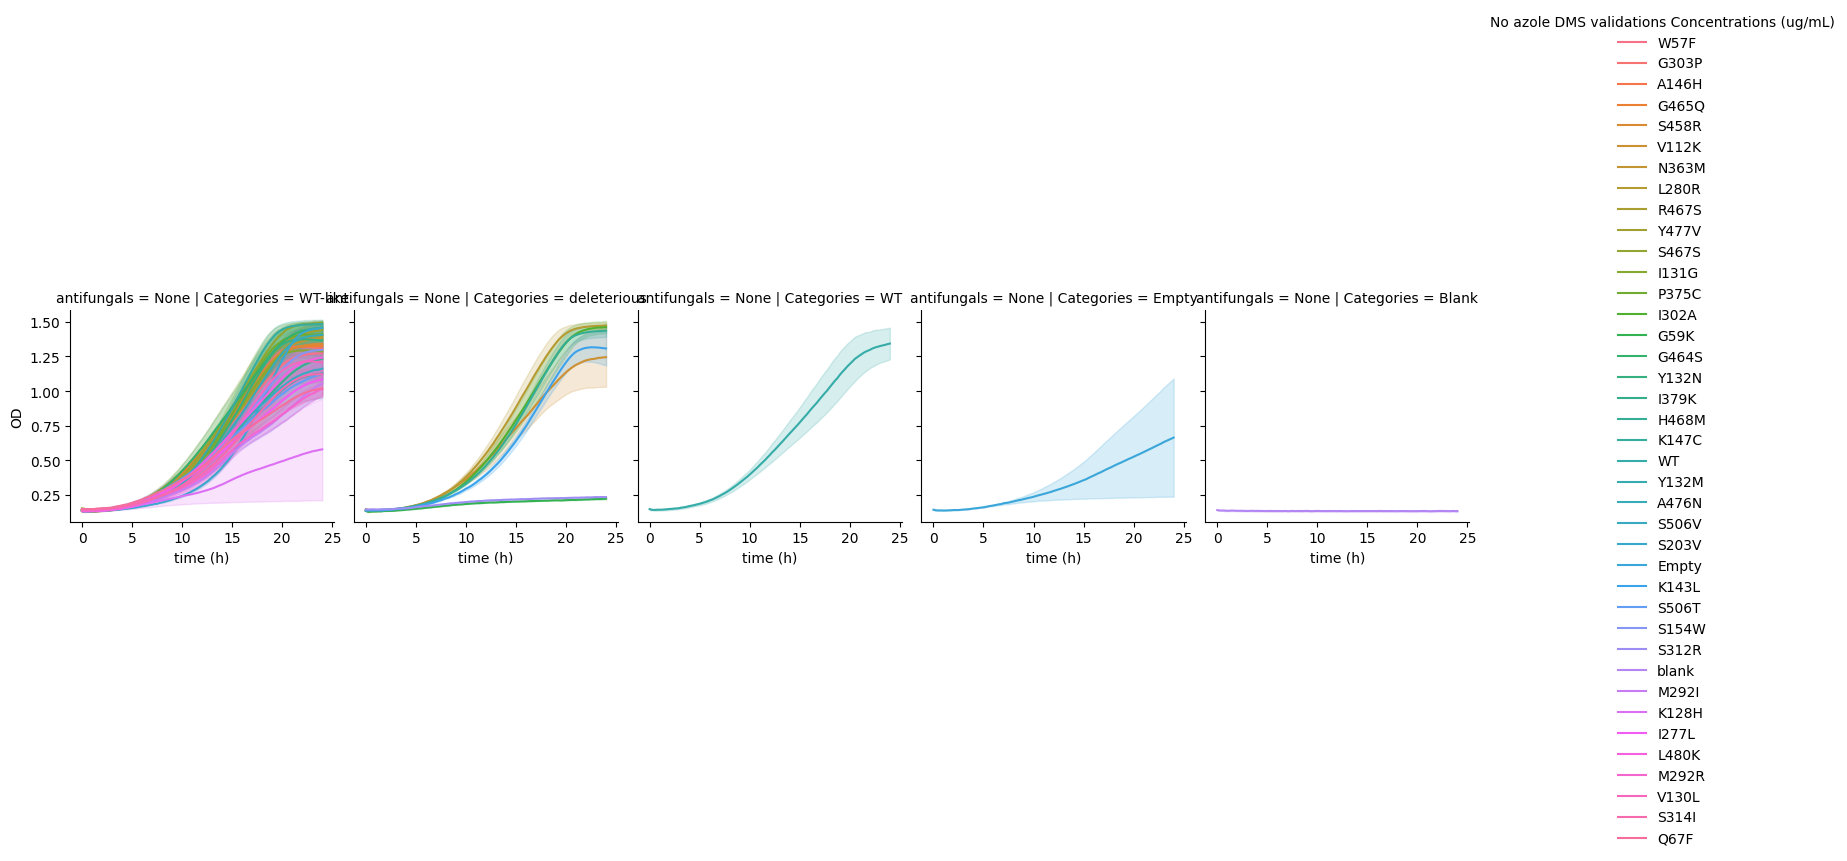

In [69]:
##Growth curves visualisation, the columns will be the different strains and the colors the different concentrations
##It can take between 30 secondes to 5 minutes to load as there is a lot of data

grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <= time], row = "antifungals",  row_order = [antifungal],col="Categories", hue="strains")
#to see only one add col_order=["name"] in sns.FacetGrid
grid.map(sns.lineplot, 'time (h)', 'OD')
grid.set_axis_labels('time (h)', 'OD')
grid.add_legend(title = (name + ' Concentrations (ug/mL)'))
grid.fig.subplots_adjust(top=0.9)

axes = grid.axes.flatten()

name1 = "GrowthCurves_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

# AUC calculations

In [13]:
#Definition of the area under the curve (AUC) calculation, the calculation is made from the ODs
def get_auc(g):
    return np.trapz(g.OD)

In [14]:
##Add the AUC on the Df without ODs to limit the quatity of data we continue with
aucdf = merged_df[merged_df['time (h)'] <= time].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc')
condensed_df = df.merge(right=aucdf, on=['well'])
condensed_df.head()

,strains,concentrations,well,antifungals,Categories,auc
0,A146H,0,A3,None,WT-like,60.051075
1,A146H,0,A8,None,WT-like,63.634435
2,A476N,0,E2,None,WT-like,54.780705
3,A476N,0,E7,None,WT-like,65.357790
4,Empty,0,E5,None,Empty,42.832545


# AUC visualisations

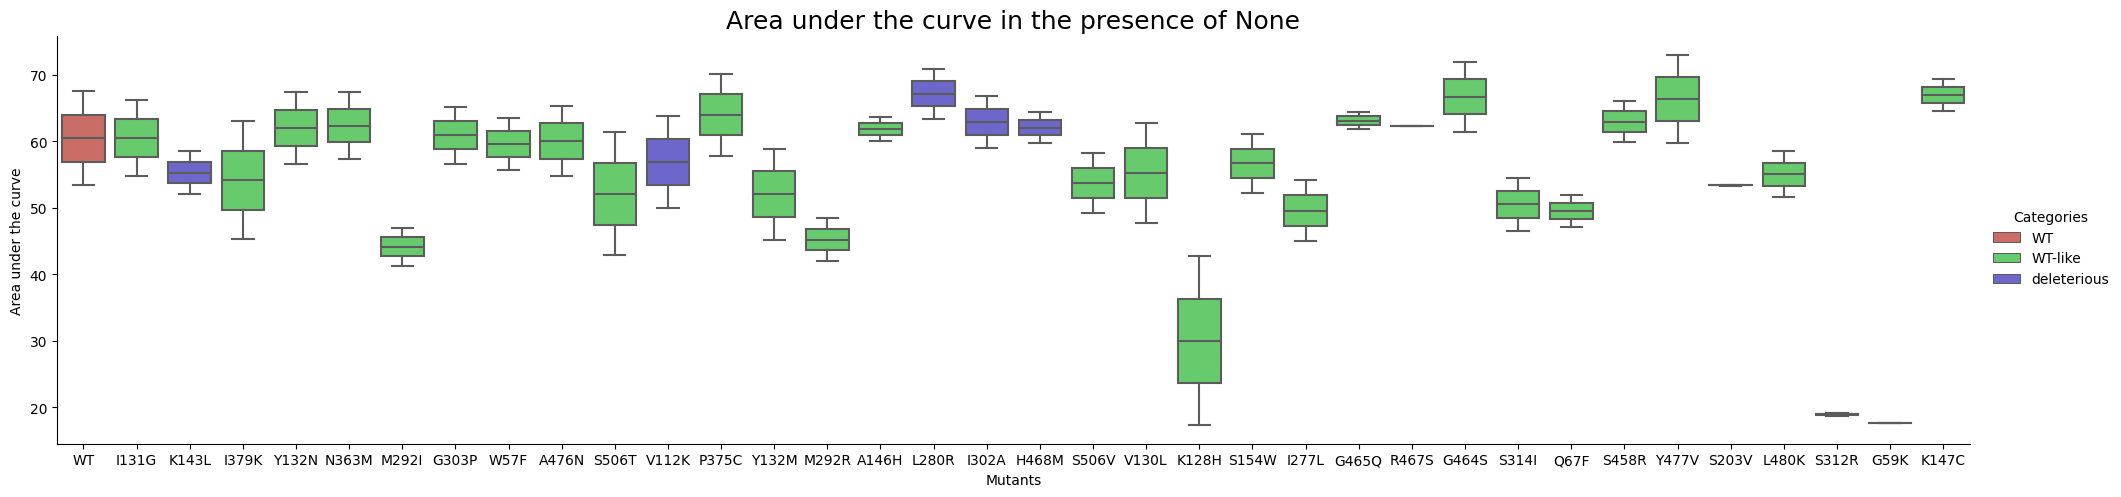

In [15]:
# Create the AUC boxplot

hue_order = ["WT", "WT-like", "deleterious"]

order = ["WT","I131G","K143L","I379K","Y132N","N363M","M292I","G303P","W57F","A476N","S506T","V112K","P375C",
                    "Y132M","M292R","A146H","L280R","I302A","H468M","S506V","V130L","K128H","S154W","I277L","G465Q",
                    "R467S","G464S","S314I","Q67F","S458R","Y477V","S203V","L480K","S312R","G59K","K147C"]


box = sns.catplot(x="strains", y="auc", col="antifungals", col_order=[antifungal],data=condensed_df, order=order, kind="box", hue = "Categories",palette="hls",
                  height=5, aspect=4, hue_order = hue_order, dodge=False) 

box.set_axis_labels('Mutants', 'Area under the curve')

plt.title("Area under the curve in the presence of " + antifungal,size=18)

# Save the figure
name1 = "Boxplot_AUC_" + name + str(time) + "H_" + date
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

plt.show()

In [16]:
#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_AUC_" + name + str(time) + "H_" + date  
condensed_df.to_excel(f"c:{name1}.xlsx", index = False)

# Correlation with DMS selection coeffcient

In [17]:
condensed_df

,strains,concentrations,well,antifungals,Categories,auc
0,A146H,0,A3,None,WT-like,60.051075
1,A146H,0,A8,None,WT-like,63.634435
2,A476N,0,E2,None,WT-like,54.780705
3,A476N,0,E7,None,WT-like,65.357790
4,Empty,0,E5,None,Empty,42.832545
...,...,...,...,...,...,...
75,blank,0,F10,None,Blank,13.838055
76,blank,0,G5,None,Blank,12.035495
77,blank,0,G10,None,Blank,12.453080
78,blank,0,H5,None,Blank,12.556910


In [18]:
# Filter rows where 'strains' is equal to 'blank' and calculate the mean of 'auc'
med_auc_blank = condensed_df[condensed_df['strains'] == 'blank']['auc'].median()

print("Median AUC for 'blank' strains:", med_auc_blank)

# Subtract the mean AUC of 'blank' from all 'auc' values
condensed_df['auc_noblank'] = condensed_df['auc'] - med_auc_blank

filtered_df = condensed_df.loc[condensed_df['antifungals'] == antifungal]
mean_df = filtered_df.groupby(["antifungals",'strains', 'Categories'])[['auc',"auc_noblank"]].mean().reset_index()
mean_df

Median AUC for 'blank' strains: 12.59627


,antifungals,strains,Categories,auc,auc_noblank
0,None,A146H,WT-like,61.842755,49.246485
1,None,A476N,WT-like,60.069247,47.472977
2,None,Empty,Empty,31.028347,18.432077
3,None,G303P,WT-like,60.971955,48.375685
4,None,G464S,WT-like,66.717893,54.121622
5,None,G465Q,WT-like,63.123125,50.526855
6,None,G59K,deleterious,17.653382,5.057113
7,None,H468M,deleterious,62.084843,49.488572
8,None,I131G,WT-like,60.481000,47.884730
9,None,I277L,WT-like,49.620575,37.024305


In [19]:
s_df = pd.read_excel(select_coef_file, header=0, index_col=0)
s_df = s_df["s_none"]

# Subtract the mean AUC of 'blank' from all 'auc' values
condensed_df['auc_noblank'] = condensed_df['auc'] - med_auc_blank

condensed_df = condensed_df.loc[condensed_df['antifungals'] == "None"]

condensed_df = condensed_df.merge(right=s_df, on=["strains"])
condensed_df = condensed_df.rename(columns={'s_none': 's'})

condensed_df["auc_noblank_log2"] = np.log2(condensed_df["auc_noblank"])
condensed_df['auc_noblank_log2_norm'] = condensed_df['auc_noblank_log2'] / condensed_df.loc[condensed_df['strains'] == 'WT', 'auc_noblank_log2'].mean()

#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_blank_auc_s_replicates_" + name + str(time) + "H_" + date  
condensed_df.to_excel(f"c:{name1}.xlsx", index = False)
condensed_df

,strains,concentrations,well,antifungals,Categories,auc,auc_noblank,s,auc_noblank_log2,auc_noblank_log2_norm
0,A146H,0,A3,None,WT-like,60.051075,47.454805,-0.002081,5.568482,1.000376
1,A146H,0,A8,None,WT-like,63.634435,51.038165,-0.002081,5.673505,1.019243
2,A476N,0,E2,None,WT-like,54.780705,42.184435,-0.030731,5.398639,0.969863
3,A476N,0,E7,None,WT-like,65.357790,52.761520,-0.030731,5.721414,1.027850
4,G303P,0,A2,None,WT-like,56.683905,44.087635,-0.028149,5.462302,0.981301
...,...,...,...,...,...,...,...,...,...,...
66,Y132M,0,E6,None,WT-like,58.924845,46.328575,-0.009569,5.533830,0.994151
67,Y132N,0,D1,None,WT-like,56.608385,44.012115,-0.028890,5.459829,0.980856
68,Y132N,0,D6,None,WT-like,67.435775,54.839505,-0.028890,5.777144,1.037862
69,Y477V,0,B5,None,WT-like,59.760030,47.163760,-0.000618,5.559607,0.998781


In [20]:
s_df = pd.read_excel(select_coef_file, header=0, index_col=0)
s_df = s_df["s_none"]

In [21]:
merged_df = mean_df.merge(right=s_df, on=["strains"])
merged_df = merged_df.rename(columns={'s_none': 's', "Categories" : "Resistance categories"})
merged_df

,antifungals,strains,Resistance categories,auc,auc_noblank,s
0,None,A146H,WT-like,61.842755,49.246485,-0.002081
1,None,A476N,WT-like,60.069247,47.472977,-0.030731
2,None,G303P,WT-like,60.971955,48.375685,-0.028149
3,None,G464S,WT-like,66.717893,54.121622,0.021436
4,None,G465Q,WT-like,63.123125,50.526855,0.014966
5,None,G59K,deleterious,17.653382,5.057113,-0.040180
6,None,H468M,deleterious,62.084843,49.488572,-0.066924
7,None,I131G,WT-like,60.481000,47.884730,-0.009754
8,None,I277L,WT-like,49.620575,37.024305,0.001895
9,None,I302A,deleterious,62.907578,50.311307,-0.070855


In [22]:
#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_blank_auc_s_" + name + str(time) + "H_" + date  
merged_df.to_excel(f"c:{name1}.xlsx", index = False)

In [23]:
name1 = "Dataframe_blank_auc_s_" + name + str(time) + "H_" + date +".xlsx" 
merged_df=pd.read_excel(name1)

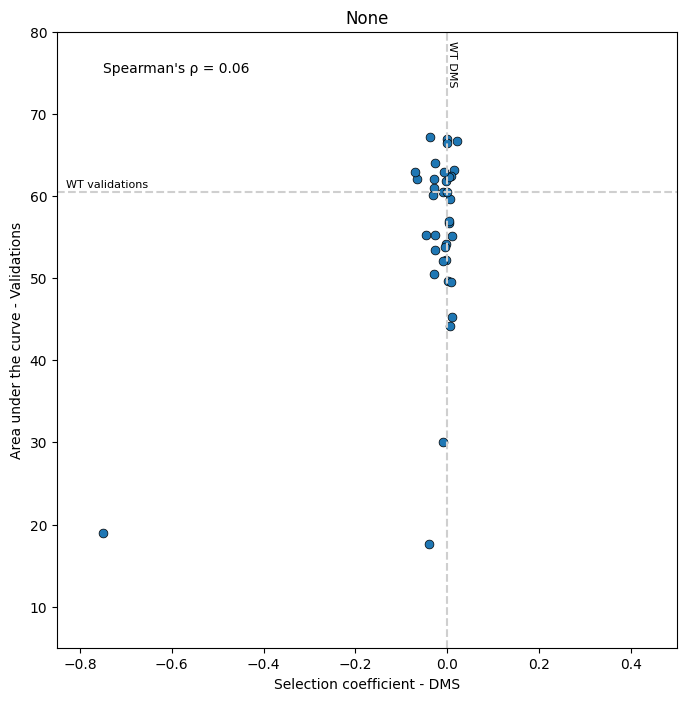

In [28]:
fig = plt.subplots(figsize=(8, 8))



sns.scatterplot(y=merged_df["auc"],
x=merged_df["s"],
edgecolor="black",s=40)

result = sp.stats.spearmanr(merged_df["auc"], merged_df["s"])
coeff = result[0]
p_value = "{:.1e}".format(result[1])
R2 = coeff**2

plt.axhline(y=60.509655, linestyle='--', color='#CFCFCF')
plt.axvline(x=0, linestyle='--', color='#CFCFCF')

plt.ylim(5, 80)
plt.xlim(-0.85, 0.5)

plt.ylabel("Area under the curve - Validations", fontsize=10)
plt.xlabel("Selection coefficient - DMS", fontsize =10)

plt.title(antifungal)

text = "Spearman's ρ = " + str(round(coeff,2))
#+ "\np-value = "  + str(p_value)
plt.text(-0.75,75, text , fontsize = 10)

plt.text(-0.83,61, "WT validations" , fontsize = 8)
plt.text(0, 73.5, "WT DMS", fontsize=8, rotation=-90)

#plt.legend(title='Resistance categories', bbox_to_anchor=(1.05, 1), loc='upper left')

#for i, row in merged_df.iterrows():
    #plt.text(row['s_fluco'], row['auc'], row['strains'], fontsize=8, ha='center', va='bottom')

name1 = "Correlation_with_select_coef_2_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

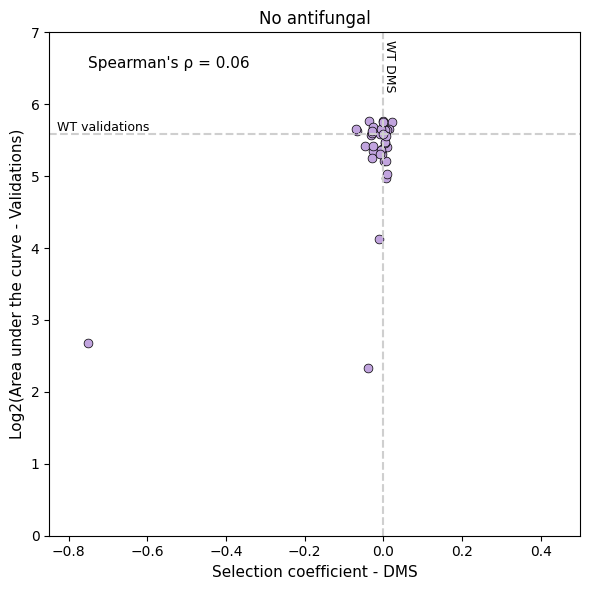

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

# Log2 transform the "auc" column
merged_df["auc_no_blank_log2"] = np.log2(merged_df["auc_noblank"])

sns.scatterplot(y=merged_df["auc_no_blank_log2"], x=merged_df["s"], color = "#C1A4DE", edgecolor="black", s=40)

result = sp.stats.spearmanr(merged_df["auc_no_blank_log2"], merged_df["s"])
coeff = result[0]
p_value = "{:.1e}".format(result[1])
R2 = coeff**2

plt.axhline(y=np.log2(47.913385), linestyle='--', color='#CFCFCF')  # Log2 transform the y-coordinate
plt.axvline(x=0, linestyle='--', color='#CFCFCF')

#plt.ylim(np.log2(5), np.log2(60))  # Set y-axis limits to log2 values
plt.xlim(-0.85, 0.5)
plt.ylim(0, 7)

plt.ylabel("Log2(Area under the curve - Validations)", fontsize=11)  # Update y-axis label
plt.xlabel("Selection coefficient - DMS", fontsize=11)

plt.title("No antifungal", fontsize=12)

text = "Spearman's ρ = " + str(round(coeff, 2))
plt.text(-0.75, 6.5, text, fontsize=11)  # Log2 transform the y-coordinate

plt.text(-0.83, np.log2(49.5), "WT validations", fontsize=9)  # Log2 transform the y-coordinate
plt.text(0, 6.2, "WT DMS", fontsize=9, rotation=-90)  # Log2 transform the y-coordinate


fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'

name1 = "Correlation_with_select_coef_auc_log2_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', transparent=True,dpi=300)
plt.savefig(f"c:{name1}.svg", format='svg', transparent=True,dpi=300)
plt.show()